# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

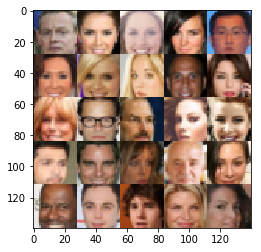

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name ='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name="learning_rate")
    return input_real, input_z, learning_rate
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Define leaky relu to get used later on
leaky_relu = lambda x, alpha : tf.maximum(x* alpha, x)
leaky_relu(-10, 0.1)

<tf.Tensor 'Maximum:0' shape=() dtype=float32>

In [7]:

def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # add kernel_initializer = tf.random_normal_initializer(stddev=0.02)
    kernel_initializer = tf.random_normal_initializer(stddev=0.02)
    padding='same'
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # size is 28x28x3
        # Revers CNN
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_initializer, padding=padding)
        x = leaky_relu(x, alpha)
        
        # size is 14x14x64
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kernel_initializer, padding=padding)
        x = leaky_relu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        
        # size is 7x7x128
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kernel_initializer, padding=padding)
        x = leaky_relu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
    return out, logits
                                 
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # add kernel_initializer = tf.random_normal_initializer(stddev=0.02)
    kernel_initializer = tf.random_normal_initializer(stddev=0.02)
    padding = "same"
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = leaky_relu(x1, alpha)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=kernel_initializer, padding=padding)
        x2 = leaky_relu(x2, alpha)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=kernel_initializer, padding=padding)
        x3 = leaky_relu(x3, alpha)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, kernel_initializer=kernel_initializer, padding=padding)
        
        #28x28x3
        
        out = tf.tanh(logits)
    return out
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # define labels
    smooth = 0.1
    real_lables = tf.ones_like(d_model_real) * (1 - smooth)
    fake_labels = tf.zeros_like(d_model_fake)
    g_labels    = tf.ones_like(d_model_fake)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_lables))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images_shown = 25
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, images_shown, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.2442
Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 1.9655
Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 3.3844
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 4.1750
Epoch 1/2... Discriminator Loss: 0.4157... Generator Loss: 3.7476
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 2.5593
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 3.7248
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 3.1089
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 3.9076
Epoch 1/2... Discriminator Loss: 0.4321... Generator Loss: 3.7020


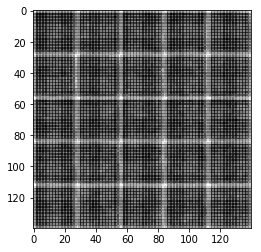

Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 1.2878
Epoch 1/2... Discriminator Loss: 2.4230... Generator Loss: 8.7404
Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 2.2425
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 2.3595
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.2875
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 1.5186
Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.1185


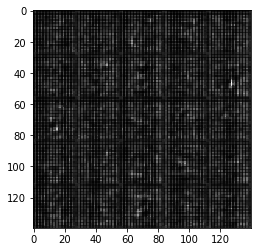

Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.6307
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.4391
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.4667
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.3126
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.6408
Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 2.0640
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 1.5075
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.7034
Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.3186
Epoch 1/2... Discriminator Loss: 0.7407... Generator Loss: 1.8416


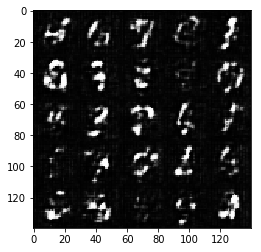

Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 2.0234
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.3561
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.4952
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.1277
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.0277
Epoch 1/2... Discriminator Loss: 0.8318... Generator Loss: 1.1595
Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 0.7792... Generator Loss: 1.3350


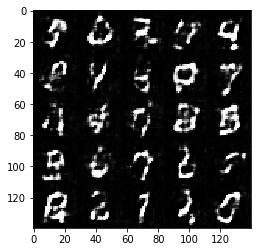

Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.2799
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.3173
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.7014
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.4462
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 0.9298... Generator Loss: 1.0650


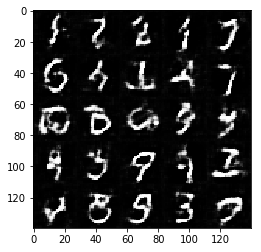

Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 2.0656
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.2782
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.5822
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 1.6561
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.0720


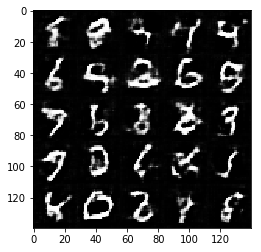

Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.1046
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.9368


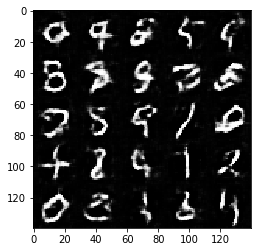

Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 1.6436
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.4308
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.9849
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.3001
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.7479
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.6582
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.0720


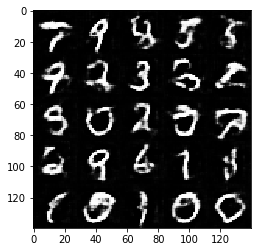

Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 0.8125... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.8917
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 1.3154
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 0.8633


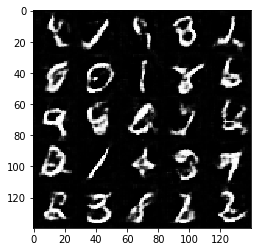

Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 0.9617
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.1900
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.5869
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.9821


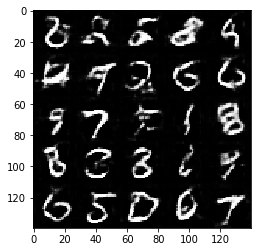

Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.8420
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 2.0419
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 1.7991
Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 0.7689


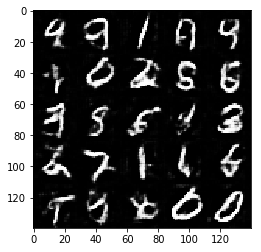

Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.2974
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 1.5733
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 0.9971
Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.5130
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.0407


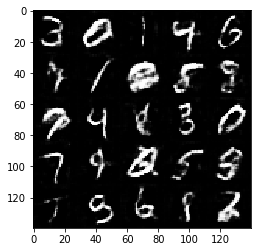

Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.5171
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.6634
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.4374
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 2.0585
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 0.8341... Generator Loss: 1.2341
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 0.7672


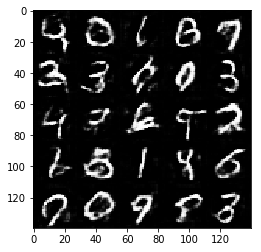

Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.7548
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 1.1494
Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.4001
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 2.6263
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.6226
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 0.4829
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.6936
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.5090


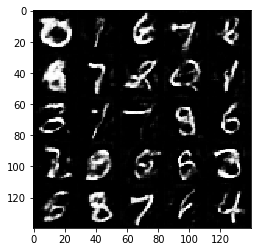

Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.6063
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.3419
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 2.0271
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 2.3225
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.9417
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.8603


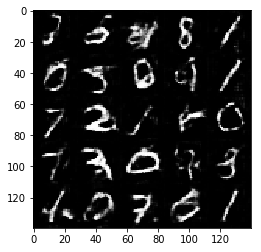

Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 1.4271
Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.4378
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.6050
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.2831


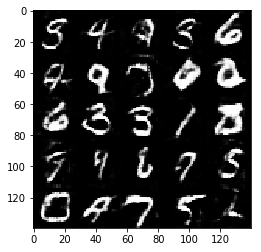

Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 3.0232
Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.3130
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.8583
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 2.1158
Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 2.3858
Epoch 2/2... Discriminator Loss: 1.8184... Generator Loss: 0.3916
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.1696


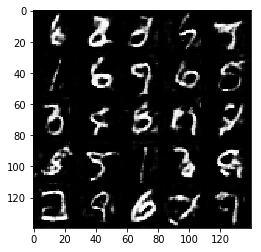

Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.3123
Epoch 2/2... Discriminator Loss: 1.6298... Generator Loss: 0.4486
Epoch 2/2... Discriminator Loss: 0.7607... Generator Loss: 1.6148
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.8247
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.9805
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.2111


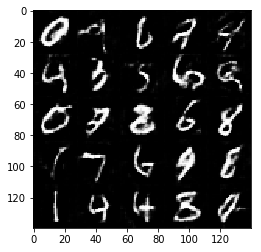

Epoch 2/2... Discriminator Loss: 1.5324... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 1.7577
Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.7543
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.5101
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.6392
Epoch 2/2... Discriminator Loss: 1.6967... Generator Loss: 0.3533


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

!pip install matplotlib==2.2.0

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 3.2871
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.8564
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 2.8867
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.2186
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.1705


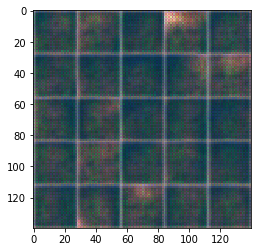

Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.9345
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 4.8937
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.7664
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.5081
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 2.0338
Epoch 1/1... Discriminator Loss: 2.1201... Generator Loss: 0.2653
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6652


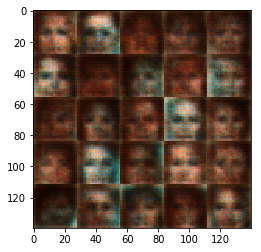

Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 2.2434... Generator Loss: 3.7510
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8905


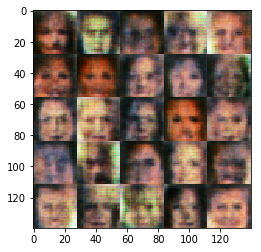

Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8835


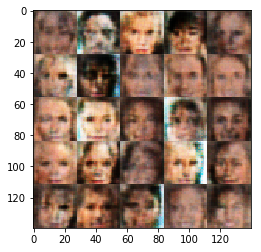

Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8986


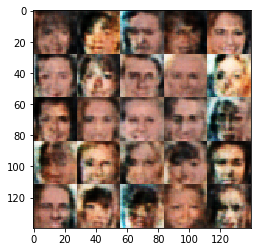

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 1.1957


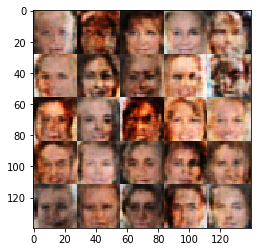

Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.7899
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.8037


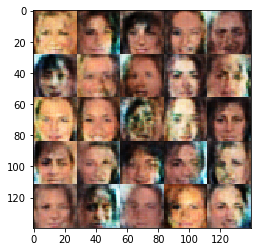

Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.3700


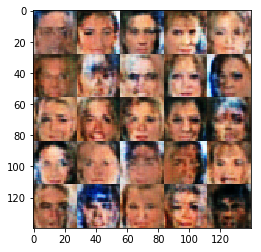

Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6841


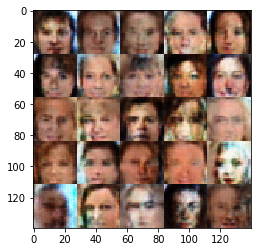

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 1.1587


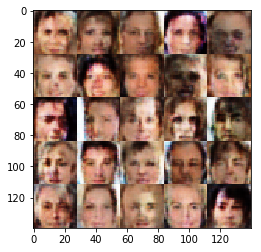

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.9800


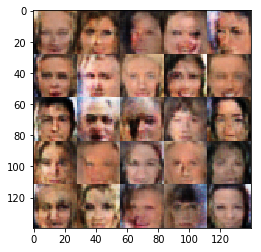

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.8915


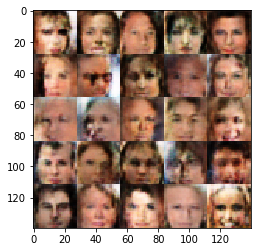

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0460


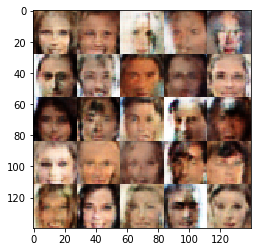

Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8759


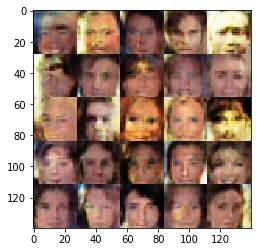

Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0255


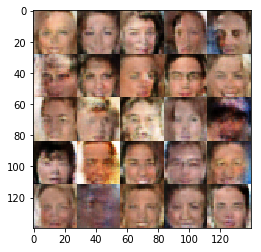

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.6720


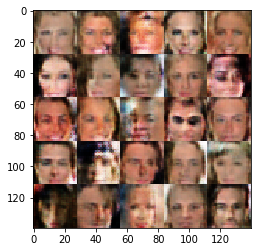

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 1.0789


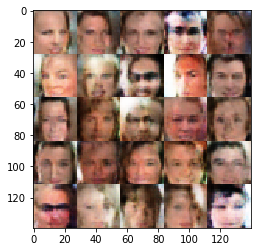

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2908


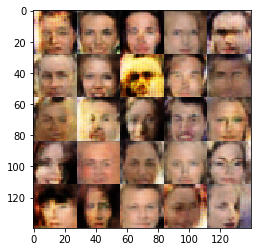

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7568


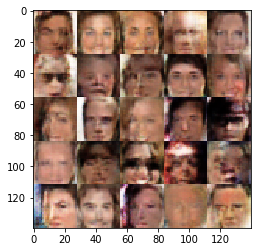

Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5389


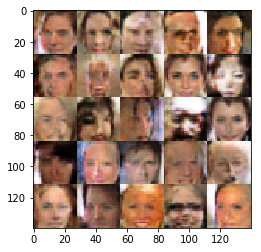

Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.0659


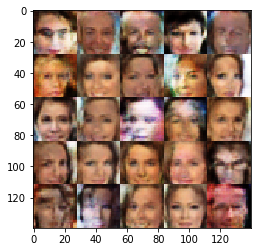

Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8449


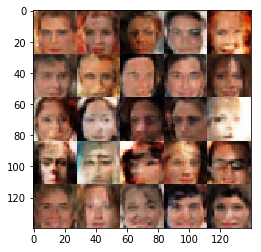

Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.5304


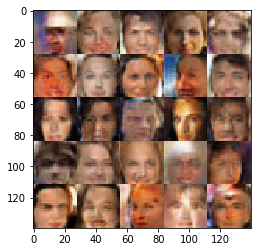

Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.0657


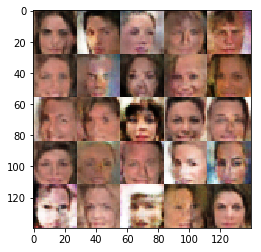

Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 1.2107
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5214


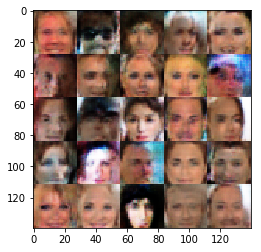

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.7236
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.7832


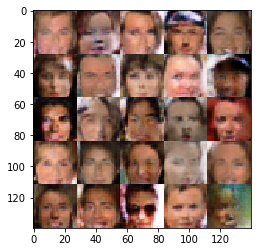

Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.6987... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.8879


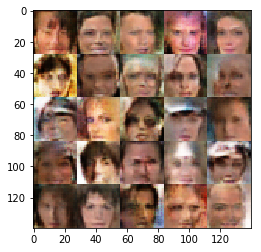

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.4759


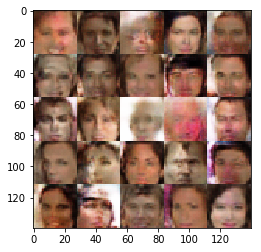

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.3795


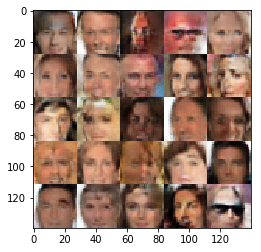

Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.5104
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.9271... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.8316


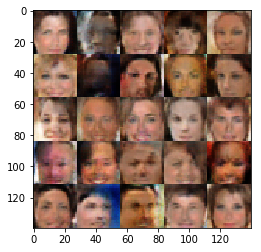

Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.0236


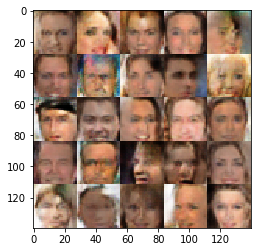

Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7283


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.